# Classifying Stages of Dementia using MRI scans

### By Casey Yoon, Christina Carr, Filippos Papapolyzos, Julie Lai

### Dataset used: [Alzheimer's Dataset (4 class of Images)](https://www.kaggle.com/tourist55/alzheimers-dataset-4-class-of-images)

## Import Statements

In [28]:
from matplotlib import image
from matplotlib import pyplot as plt
import os
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score
from skimage import filters
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from numpy import unravel_index
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Reading Files

In [4]:
def get_data(test=False, multiclass=False, visualize=False):
    
    np.random.seed(0)

    path = os.getcwd() + "/train/" # training directory
    if test == True:
        path = os.getcwd() + '/test/' # testing directory

    verymildfiles = os.listdir(path + "VeryMildDemented/")
    moderatefiles = os.listdir(path + "ModerateDemented/")
    mildfiles = os.listdir(path + "MildDemented/")
    nondementedfiles = os.listdir(path + "NonDemented/")

    verymild_images = [image.imread(path + "VeryMildDemented/" + file) for file in verymildfiles]
    moderate_images = [image.imread(path + "ModerateDemented/" + file) for file in moderatefiles]
    mild_images = [image.imread(path + "MildDemented/" + file) for file in mildfiles]
    nondemented_images = [image.imread(path + "NonDemented/" + file) for file in nondementedfiles]
    
    if visualize==True:
        scans = [nondemented_images, verymild_images, mild_images, moderate_images]
        scan_labels = ['Non-Dementia', 'Very Mild Dementia', 'Mild Dementia', 'Moderate Dementia']
        
        plt.figure()
        fig, ax = plt.subplots(4, 3, figsize=(10,10))
        for i in range(4):
            for j in range(3):
                ax[i, j].imshow(scans[i][j], cmap='Greys_r');
                ax[i, j].set_title(scan_labels[i]);
                ax[i, j].set_xticks([]);
                ax[i, j].set_yticks([]);
        plt.suptitle('Visualizing Raw Data')
        plt.show()
        
        # visualizing the filtered data 
        img = scans[0][0]
        # plt.imshow(img, cmap="gray")
        pre_hor = filters.prewitt_h(img)
        pre_ver = filters.prewitt_v(img)
        # Sobel Kernel
        ed_sobel = filters.sobel(img)
        plt.figure()
        fig, ax = plt.subplots(1,4, figsize=(10,10))
        ax[0].imshow(img, cmap="gray") # before filter
        ax[0].set_title('No Filter')
        ax[1].imshow(pre_hor, cmap="gray") #visualize prewitt horizontal
        ax[1].set_title('Prewitt Horizontal')
        ax[2].imshow(pre_ver, cmap="gray") #visualize prewitt vertical
        ax[2].set_title('Prewitt Vertical')
        ax[3].imshow(ed_sobel, cmap="gray") # visualize ed sobel
        ax[3].set_title('Ed Sobel')
        plt.suptitle('Visualizing Filters', y = 0.7)
        plt.tight_layout()
        return 
        
    if multiclass == False:
        
        # labeling dementia = 1, non-dementia = 0
        dementia_images = verymild_images + moderate_images + mild_images
        dementia_labels = np.array([1] * len(dementia_images))
        nondementia_labels = np.array([0] * len(nondemented_images))
        X = np.array(dementia_images + nondemented_images)/255. # normalizing data between 0 and 1
        X = [i.flatten() for i in X]
        Y = np.array(list(dementia_labels) + list(nondementia_labels))
        
        if test == False:
            # splitting into train/val data
            X_train, X_dev, Y_train, Y_dev = train_test_split(
                X, Y, test_size=0.25, random_state=42)
            
            return X_train,X_dev,Y_train,Y_dev
            
        elif test == True:
            return X,Y
            
    elif multiclass == True:
        # verymild=1, mild=2, moderate=3, non-dementia=0
        verymild_labels = np.array([1] * len(verymild_images))
        mild_labels = np.array([2] * len(mild_images))
        moderate_labels = np.array([3] * len(moderate_images))
        nondementia_labels = np.array([0] * len(nondemented_images))
        X = np.array(nondemented_images + verymild_images + mild_images + moderate_images)/255. # normalizing data between 0 and 1
        X = [i.flatten() for i in X]
        Y = np.array(list(nondementia_labels) + list(verymild_labels) + list(mild_labels) + list(moderate_labels))
        
        if test == False:
            # splitting into train/val data
            X_train, X_dev, Y_train, Y_dev = train_test_split(
                X, Y, test_size=0.25, random_state=42)
            
            return X_train,X_dev,Y_train,Y_dev
            
        elif test == True:
            return X,Y

## Visualizing Train Data

<Figure size 432x288 with 0 Axes>

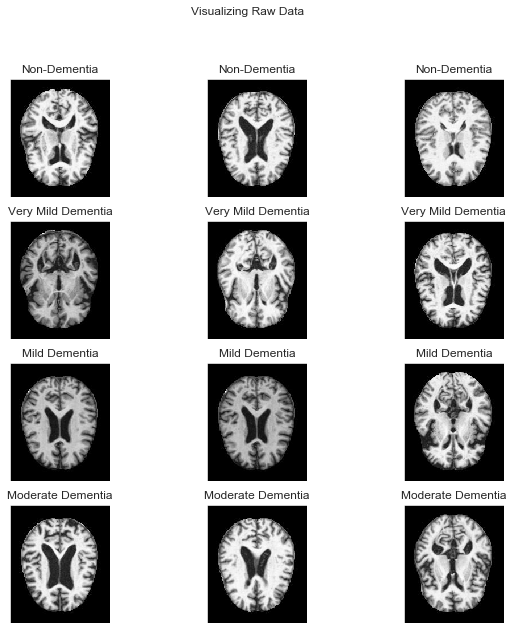

<Figure size 432x288 with 0 Axes>

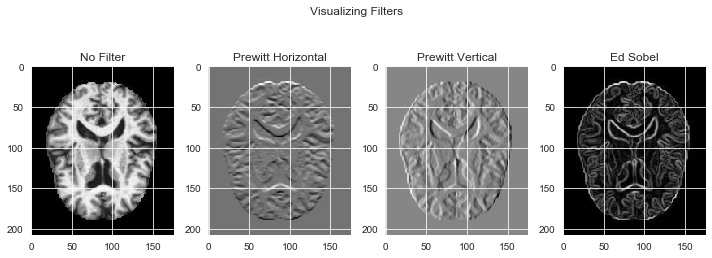

In [5]:
get_data(visualize=True)

## Visualizing test data

<Figure size 432x288 with 0 Axes>

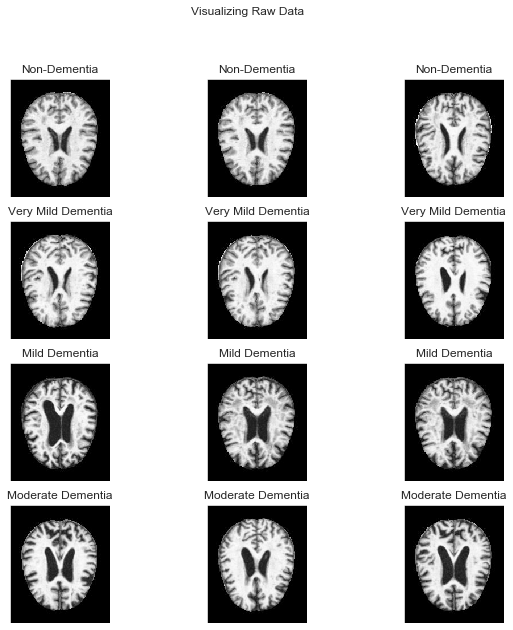

<Figure size 432x288 with 0 Axes>

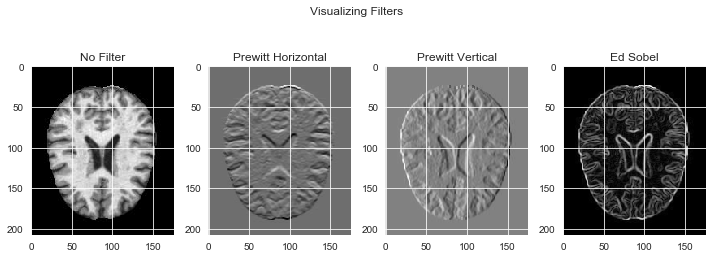

In [6]:
get_data(test=True,visualize=True)

In [7]:
# Getting train/dev data for binary class data
X_train, X_dev, Y_train, Y_dev = get_data()

# Getting test data for binary class data
X_test, Y_test = get_data(test=True)

# Getting train/dev data for multi class data
X_m_train, X_m_dev, Y_m_train, Y_m_dev = get_data(multiclass=True)

# Getting test data for multi class data
X_m_test, Y_m_test = get_data(test=True, multiclass=True)

In [8]:
# combining data and labels together so that we can make our own train and test sets
data = X_train + X_dev + X_test
labels = list(Y_train) + list(Y_dev) + list(Y_test)
data_m = X_m_train + X_m_dev + X_m_test
labels_m = list(Y_m_train) + list(Y_m_dev) + list(Y_m_test)
np.random.seed(0)
shuffle = np.random.permutation(len(data))
shuffle_m = np.random.permutation(len(data_m))
data, labels = np.array(data)[shuffle], np.array(labels)[shuffle]
data_m, labels_m = np.array(data_m)[shuffle_m], np.array(labels_m)[shuffle_m]

In [9]:
# splitting into train/dev/test into 70/20/10
X_train, X_dev, X_test = data[:4480], data[4480:5760], data[5760:]
Y_train, Y_dev, Y_test = labels[:4480], labels[4480:5760], labels[5760:]
X_m_train, X_m_dev, X_m_test = data_m[:4480], data_m[4480:5760], data_m[5760:]
Y_m_train, Y_m_dev, Y_m_test = labels_m[:4480], labels_m[4480:5760], labels_m[5760:]

In [10]:
# counting the number of images per class
print('Binary Class')
print(f'Train: {Counter(Y_train)}')
print(f'Dev: {Counter(Y_dev)}')
print(f'Test: {Counter(Y_test)}')

print('\nMulti Class')
print(f'Train: {Counter(Y_m_train)}')
print(f'Dev: {Counter(Y_m_dev)}')
print(f'Test: {Counter(Y_m_test)}')

Binary Class
Train: Counter({1: 2253, 0: 2227})
Dev: Counter({1: 640, 0: 640})
Test: Counter({0: 333, 1: 307})

Multi Class
Train: Counter({0: 2274, 1: 1534, 2: 635, 3: 37})
Dev: Counter({0: 617, 1: 465, 2: 177, 3: 21})
Test: Counter({0: 309, 1: 241, 2: 84, 3: 6})


## 3D PCA

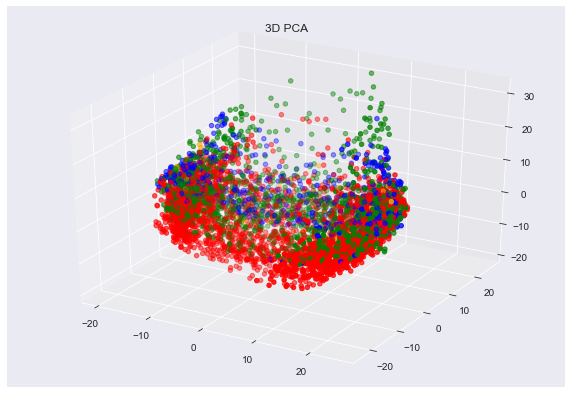

In [9]:
pca = PCA(n_components=3)
pca_train = pca.fit_transform(X_m_train)
pca_dev = pca.transform(X_m_dev)

xs = [i[0] for i in pca_train]
ys = [i[1] for i in pca_train]
zs = [i[2] for i in pca_train]
colors = []
for k in range(len(pca_train)):
    if Y_m_train[k] == 0:
        colors.append('r')
    elif Y_m_train[k] == 1:
        colors.append('g')
    elif Y_m_train[k] == 2:
        colors.append('b')
    elif Y_m_train[k] == 3:
        colors.append('orange')

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs,ys,zs,c=colors)
plt.title('3D PCA')
plt.show()

## Keras (TensorFlow)

### Load and create datasets

In [10]:
batch_size = 32
img_height = 180
img_width = 180
path = os.getcwd() + '/train'
test_path = os.getcwd() + '/test'

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.


In [12]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


### Configure dataset for performance
Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

Dataset.prefetch() overlaps data preprocessing and model execution while training.



In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

In [15]:
from tensorflow.keras.models import Sequential
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Train the model

In [18]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
129/129 [==============================] - 81s 626ms/step - loss: 1.0505 - accuracy: 0.5050 - val_loss: 0.9300 - val_accuracy: 0.6016
Epoch 2/10
129/129 [==============================] - 98s 760ms/step - loss: 0.8400 - accuracy: 0.6197 - val_loss: 0.8341 - val_accuracy: 0.6357
Epoch 3/10
129/129 [==============================] - 89s 692ms/step - loss: 0.5764 - accuracy: 0.7620 - val_loss: 0.4736 - val_accuracy: 0.7959
Epoch 4/10
129/129 [==============================] - 91s 707ms/step - loss: 0.3419 - accuracy: 0.8662 - val_loss: 0.3123 - val_accuracy: 0.8730
Epoch 5/10
129/129 [==============================] - 87s 673ms/step - loss: 0.1593 - accuracy: 0.9431 - val_loss: 0.1817 - val_accuracy: 0.9355
Epoch 6/10
129/129 [==============================] - 90s 694ms/step - loss: 0.0809 - accuracy: 0.9744 - val_loss: 0.1197 - val_accuracy: 0.9561
Epoch 7/10
129/129 [==============================] - 94s 726ms/step - loss: 0.0300 - accuracy: 0.9924 - val_loss: 0.0947 - val_ac

### Visualize training results

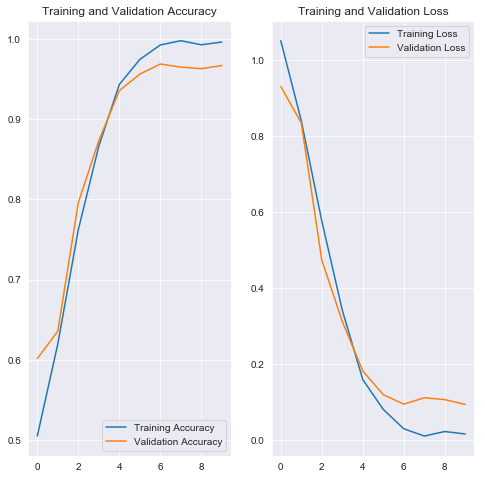

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Predict on Test Data

In [20]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1279 files belonging to 4 classes.


In [21]:
test_loss, test_acc = model.evaluate(test_ds)

print('\nTest accuracy:', test_acc)

40/40 [==============================] - 9s 231ms/step - loss: 2.2621 - accuracy: 0.6271

Test accuracy: 0.627052366733551


## Naive Bayes Models (without PCA)

In [22]:
## making function to preprocess data into 0,1,2
def preprocess(data):
    full_preprocessed_data = []

    for number in data:
        preprocessed_number = []
        for pixel in number:
            if pixel < 0.33:
                preprocessed_number.append(0) # white
            elif pixel > 0.33 and pixel < 0.66:
                preprocessed_number.append(1) # grey
            else:
                preprocessed_number.append(2) # black

        full_preprocessed_data.append(preprocessed_number)

    return full_preprocessed_data

In [23]:
def naive_bayes(train_data,train_labels,dev_data,dev_labels):
    
    # Horizontal filter
    preh_train = np.array([filters.prewitt_h(i.reshape(208,176)).flatten() for i in train_data])
    preh_dev = np.array([filters.prewitt_h(i.reshape(208,176)).flatten() for i in dev_data])

    # Vertical filter
    prev_train = np.array([filters.prewitt_v(i.reshape(208,176)).flatten() for i in train_data])
    prev_dev = np.array([filters.prewitt_v(i.reshape(208,176)).flatten() for i in dev_data])

    # Ed Sobel filter
    sobel_train = np.array([filters.sobel(i.reshape(208,176)).flatten() for i in train_data])
    sobel_dev = np.array([filters.sobel(i.reshape(208,176)).flatten() for i in dev_data])

    train_data_list = [train_data, preh_train, prev_train, sobel_train]
    dev_data_list = [dev_data, preh_dev, prev_dev, sobel_dev]
    filter_names = ['None', 'Horizontal', 'Vertical', 'Sobel']
    
    acc_list = []
    nb_list = []
    filter_list = []
    
    # only testing 3 alphas for the sake of time
    # from previous analysis, these alphas generally had the highest or similar accuracy scores
    alpha = [0.001, 0.01, 0.1]
    for a in alpha:
        for i in range(len(train_data_list)):
            print(f'alpha={a}, filter={filter_names[i]}')
            
            # BernoulliNB
            bnb = BernoulliNB(alpha = a, binarize=0.5) # we are binarizing because Bernoulli takes binarized data
            bnb.fit(train_data_list[i], train_labels)
            y_pred_bnb = bnb.predict(dev_data_list[i])
            bnb_accuracy = accuracy_score(dev_labels, y_pred_bnb)
            acc_list.append(bnb_accuracy)
            nb_list.append('BernoulliNB')
            filter_list.append(filter_names[i])

            # MultinomialNB
            mnb = MultinomialNB(alpha=a)
            mnb.fit(preprocess(train_data_list[i]), train_labels)
            y_pred_mnb = mnb.predict(preprocess(dev_data_list[i]))
            mnb_accuracy = accuracy_score(dev_labels, y_pred_mnb)
            acc_list.append(mnb_accuracy)
            nb_list.append('MultinomialNB')
            filter_list.append(filter_names[i])
        
    data_list = [alpha*len(train_data_list)*2, nb_list, filter_list, acc_list]
    cols = ['Alpha', 'Naive Bayes', 'Filter', 'Accuracy']
    nb_df = pd.DataFrame(data_list).T
    nb_df.columns = cols
    
    return nb_df  

In [24]:
df = naive_bayes(X_train,Y_train,X_dev,Y_dev) # binary class
df_multi = naive_bayes(X_m_train,Y_m_train,X_m_dev,Y_m_dev) # multi class

alpha=0.001, filter=None
alpha=0.001, filter=Horizontal
alpha=0.001, filter=Vertical
alpha=0.001, filter=Sobel
alpha=0.01, filter=None
alpha=0.01, filter=Horizontal
alpha=0.01, filter=Vertical
alpha=0.01, filter=Sobel
alpha=0.1, filter=None
alpha=0.1, filter=Horizontal
alpha=0.1, filter=Vertical
alpha=0.1, filter=Sobel
alpha=0.001, filter=None
alpha=0.001, filter=Horizontal
alpha=0.001, filter=Vertical
alpha=0.001, filter=Sobel
alpha=0.01, filter=None
alpha=0.01, filter=Horizontal
alpha=0.01, filter=Vertical
alpha=0.01, filter=Sobel
alpha=0.1, filter=None
alpha=0.1, filter=Horizontal
alpha=0.1, filter=Vertical
alpha=0.1, filter=Sobel


Text(0.5, 1.0, 'Plotting Accuracy for Different Variations of Filters and NB Models (Binary Class)')

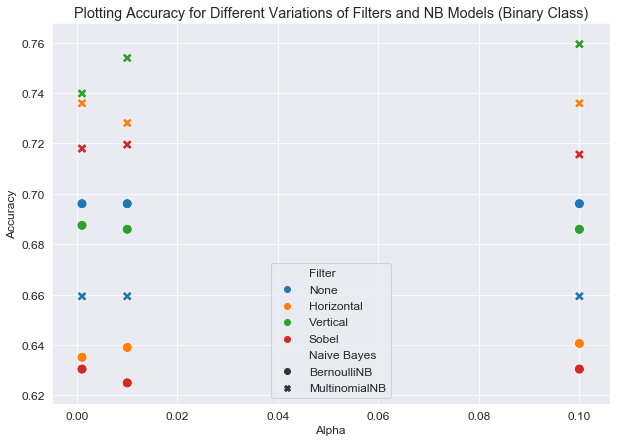

In [25]:
# plotting naive bayes accuracies for binary class data

plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 12})
sns.scatterplot(data=df, x='Alpha', y='Accuracy', hue = 'Filter', style = 'Naive Bayes', s=100)
plt.title('Plotting Accuracy for Different Variations of Filters and NB Models (Binary Class)')

Text(0.5, 1.0, 'Plotting Accuracy for Different Variations of Filters and NB Models (Multi Class)')

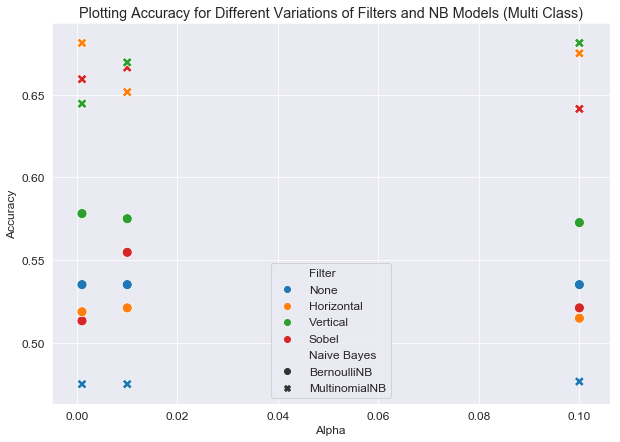

In [26]:
# plotting naive bayes accuracies for multi class data

plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 12})
sns.scatterplot(data=df_multi, x='Alpha', y='Accuracy', hue = 'Filter', style = 'Naive Bayes', s=100)
plt.title('Plotting Accuracy for Different Variations of Filters and NB Models (Multi Class)')

### Using best params to check accuracy on test data

In [27]:
# get best params
best_params = df[df.Accuracy == max(df.Accuracy)] # binary 
best_m_params = df_multi[df_multi.Accuracy == max(df_multi.Accuracy)] # multi

In [28]:
best_params

,Alpha,Naive Bayes,Filter,Accuracy
5,0.1,MultinomialNB,Vertical,0.759375


In [36]:
best_m_params.head(1) # there were 2 of the same accuracy so using the first one

,Alpha,Naive Bayes,Filter,Accuracy
3,0.001,MultinomialNB,Horizontal,0.68125


In [31]:
def NB_test(df, train_data, train_labels, test_data, test_labels):
    if (df.Filter == 'Horizontal').any():
        # Horizontal filter
        train_data = np.array([filters.prewitt_h(i.reshape(208,176)).flatten() for i in train_data])
        test_data = np.array([filters.prewitt_h(i.reshape(208,176)).flatten() for i in test_data])
    elif (df.Filter == 'Vertical').any():
        # Vertical filter
        train_data = np.array([filters.prewitt_v(i.reshape(208,176)).flatten() for i in train_data])
        test_data = np.array([filters.prewitt_v(i.reshape(208,176)).flatten() for i in test_data])

    mnb = MultinomialNB(alpha=df.Alpha.any())
    mnb.fit(preprocess(train_data), train_labels)
    y_pred_mnb = mnb.predict(preprocess(test_data))
    mnb_accuracy = accuracy_score(test_labels, y_pred_mnb)
    class_rep = classification_report(test_labels, y_pred_mnb)
    
    return mnb_accuracy, class_rep


In [38]:
bi_acc, bi_class = NB_test(best_params, X_train, Y_train, X_test, Y_test)
multi_acc, multi_class = NB_test(best_m_params, X_m_train, Y_m_train, X_m_test, Y_m_test)

print(f'Accuracy (binary class): {bi_acc}')
print(f'Classification report (binary class) \n: {bi_class}')
print(f'Accuracy (multi class): {multi_acc}')
print(f'Classification report (multi class) \n: {multi_class}')

Accuracy (binary class): 0.721875
Classification report (binary class) 
:               precision    recall  f1-score   support

           0       0.73      0.73      0.73       333
           1       0.71      0.71      0.71       307

   micro avg       0.72      0.72      0.72       640
   macro avg       0.72      0.72      0.72       640
weighted avg       0.72      0.72      0.72       640

Accuracy (multi class): 0.6734375
Classification report (multi class) 
:               precision    recall  f1-score   support

           0       0.72      0.82      0.77       309
           1       0.68      0.56      0.61       241
           2       0.48      0.50      0.49        84
           3       0.50      0.17      0.25         6

   micro avg       0.67      0.67      0.67       640
   macro avg       0.59      0.51      0.53       640
weighted avg       0.67      0.67      0.67       640



### Conclusion: overfitting

## Naive Bayes Models (with PCA) 
### We chose to not use filters because there were problems with reshaping after PCA transformation

In [39]:
def NB_pca(train_data, train_labels, dev_data, dev_labels):
    
    acc_list = []
    a_list = []
    pca_list = []
    for n_pca in [2, 5, 10, 50]:
        # producing principal component analysis to transform train and test data
        pca = PCA(n_components=n_pca)
        pca_train = pca.fit_transform(train_data)
        pca_dev = pca.transform(dev_data)
        
        for a in [0.001,0.01,0.1]:
            mnb = MultinomialNB(alpha=a)
            mnb.fit(preprocess(pca_train), train_labels)
            y_pred_mnb = mnb.predict(preprocess(pca_dev))
            mnb_accuracy = accuracy_score(dev_labels, y_pred_mnb)
            acc_list.append(mnb_accuracy)
            a_list.append(a)
            pca_list.append(n_pca)
            print(f'n_pca={n_pca}, alpha={a}, acc:{mnb_accuracy}')
    
    df = pd.DataFrame([pca_list,a_list,acc_list]).T
    df.columns = ['n_pca', 'alpha', 'accuracy']
    
    return df


In [40]:
nb_df = NB_pca(X_train,Y_train,X_dev,Y_dev) # binary class
nb_m_df = NB_pca(X_m_train,Y_m_train,X_m_dev,Y_m_dev) # multi class

n_pca=2, alpha=0.001, acc:0.51328125
n_pca=2, alpha=0.01, acc:0.51328125
n_pca=2, alpha=0.1, acc:0.51328125
n_pca=5, alpha=0.001, acc:0.60703125
n_pca=5, alpha=0.01, acc:0.60703125
n_pca=5, alpha=0.1, acc:0.60703125
n_pca=10, alpha=0.001, acc:0.64921875
n_pca=10, alpha=0.01, acc:0.64921875
n_pca=10, alpha=0.1, acc:0.64921875
n_pca=50, alpha=0.001, acc:0.65390625
n_pca=50, alpha=0.01, acc:0.65390625
n_pca=50, alpha=0.1, acc:0.65390625
n_pca=2, alpha=0.001, acc:0.49453125
n_pca=2, alpha=0.01, acc:0.49453125
n_pca=2, alpha=0.1, acc:0.49453125
n_pca=5, alpha=0.001, acc:0.50625
n_pca=5, alpha=0.01, acc:0.50625
n_pca=5, alpha=0.1, acc:0.50625
n_pca=10, alpha=0.001, acc:0.5328125
n_pca=10, alpha=0.01, acc:0.5328125
n_pca=10, alpha=0.1, acc:0.5328125
n_pca=50, alpha=0.001, acc:0.565625
n_pca=50, alpha=0.01, acc:0.565625
n_pca=50, alpha=0.1, acc:0.565625


Text(0.5, 1.0, 'Plotting Accuracy for Different Variations of PCA components and Alphas (Binary Class)')

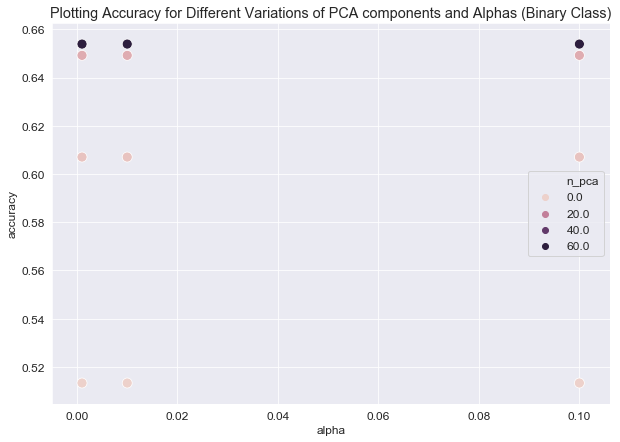

In [41]:
# plotting naive bayes accuracies with PCA for binary class

plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 12})
sns.scatterplot(data=nb_df, x='alpha', y='accuracy', hue = 'n_pca', s=100)
plt.title('Plotting Accuracy for Different Variations of PCA components and Alphas (Binary Class)')

Text(0.5, 1.0, 'Plotting Accuracy for Different Variations of PCA components and Alphas (Multi Class)')

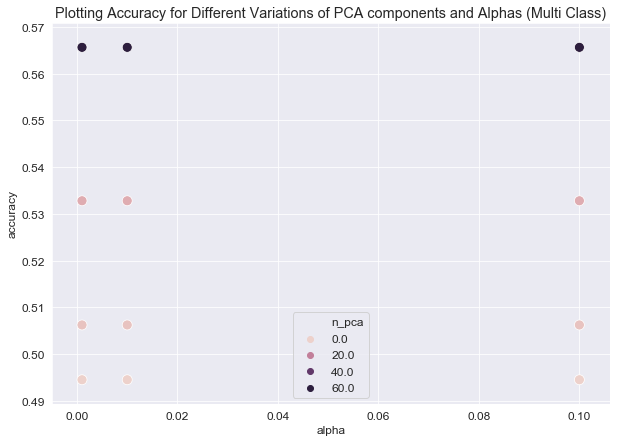

In [42]:
# plotting naive bayes accuracies with PCA for multi class

plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 12})
sns.scatterplot(data=nb_m_df, x='alpha', y='accuracy', hue = 'n_pca', s=100)
plt.title('Plotting Accuracy for Different Variations of PCA components and Alphas (Multi Class)')

### Using best params to check accuracy on test data

In [43]:
# get best params
best_params = nb_df[nb_df.accuracy == max(nb_df.accuracy)]
best_m_params = nb_m_df[nb_m_df.accuracy == max(nb_m_df.accuracy)]

In [48]:
best_params.head(1)

,n_pca,alpha,accuracy
9,50.0,0.001,0.653906


In [49]:
best_m_params.head(1)

,n_pca,alpha,accuracy
9,50.0,0.001,0.565625


In [51]:
def nbpca_test(df, train_data, train_labels, test_data, test_labels):
    # get best parameters
    best_params = df[df.accuracy == max(df.accuracy)]
    
    # transform data into pca
    pca = PCA(n_components=int(best_params.n_pca.tolist()[0]))
    pca_train = pca.fit_transform(train_data)
    pca_test = pca.transform(test_data)
    
    mnb = MultinomialNB(alpha=int(best_params.alpha.tolist()[0]))
    mnb.fit(preprocess(pca_train), train_labels)
    y_pred_mnb = mnb.predict(preprocess(pca_test))
    mnb_accuracy = accuracy_score(test_labels, y_pred_mnb)
    class_rep = classification_report(test_labels, y_pred_mnb)
    
    return mnb_accuracy, class_rep


In [52]:
bi_acc, bi_class = nbpca_test(nb_df, X_train, Y_train, X_test, Y_test)
multi_acc, multi_class = nbpca_test(nb_m_df, X_m_train, Y_m_train, X_m_test, Y_m_test)

print(f'Accuracy (binary class): {bi_acc}')
print(f'Classification report (binary class) \n: {bi_class}')
print(f'Accuracy (multi class): {multi_acc}')
print(f'Classification report (multi class) \n: {multi_class}')

/Users/julielai/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Accuracy (binary class): 0.6703125
Classification report (binary class) 
:               precision    recall  f1-score   support

           0       0.71      0.62      0.66       333
           1       0.64      0.72      0.68       307

   micro avg       0.67      0.67      0.67       640
   macro avg       0.67      0.67      0.67       640
weighted avg       0.67      0.67      0.67       640

Accuracy (multi class): 0.5484375
Classification report (multi class) 
:               precision    recall  f1-score   support

           0       0.59      0.78      0.67       309
           1       0.48      0.40      0.44       241
           2       0.43      0.15      0.23        84
           3       0.67      0.33      0.44         6

   micro avg       0.55      0.55      0.55       640
   macro avg       0.54      0.42      0.44       640
weighted avg       0.53      0.55      0.52       640



/Users/julielai/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


### Conclusion: Multinomial Naive Bayes performs worse with PCA. This is probably because PCA transformation takes away important information when reducing dimensionality.

## Random Forest

In [11]:
def RandomForests(pca=False):
    
    estimators = [10, 50, 100, 500]
    n_components = [2, 3, 5, 10, 20, 50]
    
    accuracies = []
    accuracies_m = []
    
    if pca==False:
        for n in estimators:
            forest = RandomForestClassifier(n_estimators=n)
            forest.fit(X_train, Y_train)

            print("Random Forest with {} estimators and 2 classes".format(n))
            predictions = forest.predict(X_dev)
            accuracy = accuracy_score(Y_dev, predictions)
            print('Accuracy:', accuracy)
            accuracies.append(accuracy)

            forest_m = RandomForestClassifier(n_estimators=n)
            forest_m.fit(X_m_train, Y_m_train)

            print("Random Forest with {} estimators and 4 classes".format(n))
            predictions_m = forest_m.predict(X_m_dev)
            accuracy_m = accuracy_score(Y_m_dev, predictions_m)
            print('Accuracy:', accuracy_m)
            accuracies_m.append(accuracy_m)
    
    elif pca==True:
        for n in estimators:
            for c in n_components:
                
                pca = PCA(n_components=c)
                pca_train = pca.fit_transform(X_train)
                pca_dev = pca.transform(X_dev)
    
                forest = RandomForestClassifier(n_estimators=n)
                forest.fit(pca_train, Y_train)

                print("Random Forest with {} PCA components, {} estimators and 2 classes".format(c, n))
                predictions = forest.predict(pca_dev)
                accuracy = accuracy_score(Y_dev, predictions)
                print('Accuracy:', accuracy)
                accuracies.append(accuracy)
                
                pca_m = PCA(n_components=c)
                pca_m_train = pca_m.fit_transform(X_m_train)
                pca_m_dev = pca_m.transform(X_m_dev)
    
                forest_m = RandomForestClassifier(n_estimators=n)
                forest_m.fit(pca_m_train, Y_m_train)

                print("Random Forest with {} PCA components, {} estimators and 4 classes".format(c, n))
                predictions_m = forest_m.predict(pca_m_dev)
                accuracy_m = accuracy_score(Y_m_dev, predictions_m)
                print('Accuracy:', accuracy_m)
                accuracies_m.append(accuracy_m)
                
    return accuracies, accuracies_m

In [12]:
acc, acc_m = RandomForests(pca=True)

Random Forest with 2 PCA components, 10 estimators and 2 classes
Accuracy: 0.6171875
Random Forest with 2 PCA components, 10 estimators and 4 classes
Accuracy: 0.46328125
Random Forest with 3 PCA components, 10 estimators and 2 classes
Accuracy: 0.6328125
Random Forest with 3 PCA components, 10 estimators and 4 classes
Accuracy: 0.50078125
Random Forest with 5 PCA components, 10 estimators and 2 classes
Accuracy: 0.6765625
Random Forest with 5 PCA components, 10 estimators and 4 classes
Accuracy: 0.56953125
Random Forest with 10 PCA components, 10 estimators and 2 classes
Accuracy: 0.74921875
Random Forest with 10 PCA components, 10 estimators and 4 classes
Accuracy: 0.65625
Random Forest with 20 PCA components, 10 estimators and 2 classes
Accuracy: 0.828125
Random Forest with 20 PCA components, 10 estimators and 4 classes
Accuracy: 0.7515625
Random Forest with 50 PCA components, 10 estimators and 2 classes
Accuracy: 0.85625
Random Forest with 50 PCA components, 10 estimators and 4 cla

In [13]:
estimators = [10, 50, 100, 500]
n_components = [2, 3, 5, 10, 20, 50]

acc = np.array(acc).reshape(4,6)
acc_m = np.array(acc_m).reshape(4,6)

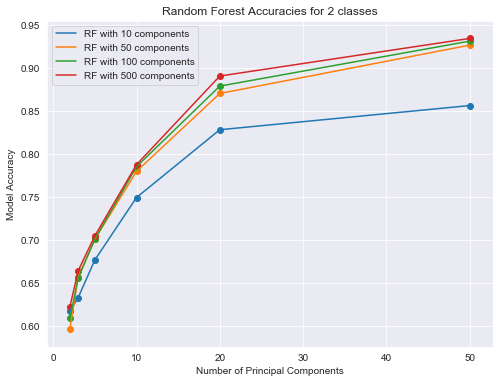

In [14]:
# plotting random forest accuracies for different PCA components and RF estimators (binary class)

fig, ax = plt.subplots(figsize=(8,6))
ax.set_title("Random Forest Accuracies for 2 classes")
ax.set_ylabel("Model Accuracy")
ax.set_xlabel("Number of Principal Components")
for i in range(len(estimators)):
    ax.plot(n_components, acc[i], label = "RF with " + str(estimators[i])+" components")
    ax.scatter(n_components, acc[i]) 
plt.legend()
plt.show()

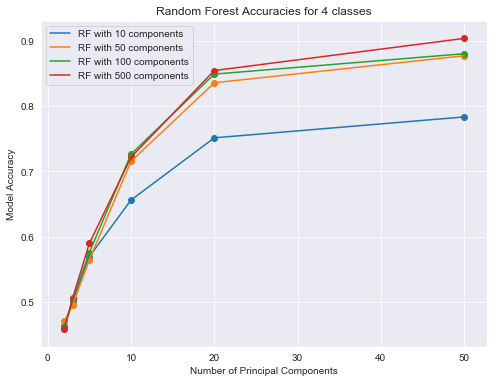

In [15]:
# plotting random forest accuracies for different PCA components and RF estimators (multi class)

fig, ax = plt.subplots(figsize=(8,6))
ax.set_title("Random Forest Accuracies for 4 classes")
ax.set_ylabel("Model Accuracy")
ax.set_xlabel("Number of Principal Components")
for i in range(len(estimators)):
    ax.plot(n_components, acc_m[i], label = "RF with " + str(estimators[i])+" components")
    ax.scatter(n_components, acc_m[i]) 
plt.legend()
plt.show()

### Using best params to check accuracy on test data

In [16]:
def get_best_params(accuracies):
    x,y = unravel_index(accuracies.argmax(), accuracies.shape)[0], unravel_index(accuracies.argmax(), accuracies.shape)[1]
    return estimators[x], n_components[y]            

In [17]:
parameters = get_best_params(acc)

pca = PCA(n_components=parameters[1])
pca_train = pca.fit_transform(X_train)
pca_test = pca.transform(X_test)

forest = RandomForestClassifier(n_estimators=parameters[0])
forest.fit(pca_train, Y_train)

print("Random Forest with {} PCA components, {} estimators and 2 classes".format(parameters[1], parameters[0]))
predictions = forest.predict(pca_test)
accuracy = accuracy_score(Y_test, predictions)
print('Accuracy:', accuracy)

Random Forest with 50 PCA components, 500 estimators and 2 classes
Accuracy: 0.9375


In [18]:
parameters_m = get_best_params(acc_m)

pca_m = PCA(n_components=parameters_m[1])
pca_m_train = pca_m.fit_transform(X_m_train)
pca_m_test = pca_m.transform(X_m_test)

forest_m = RandomForestClassifier(n_estimators=parameters_m[0])
forest_m.fit(pca_m_train, Y_m_train)

print("Random Forest with {} PCA components, {} estimators and 4 classes".format(parameters_m[1], parameters_m[0]))
predictions_m = forest_m.predict(pca_m_test)
accuracy_m = accuracy_score(Y_m_test, predictions_m)
print('Accuracy:', accuracy_m)

Random Forest with 50 PCA components, 500 estimators and 4 classes
Accuracy: 0.903125


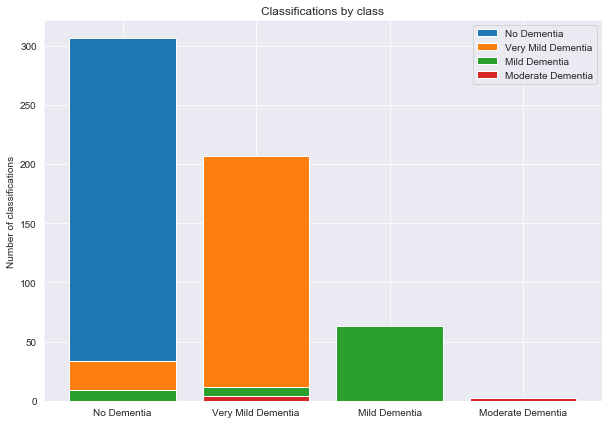

In [53]:
confused = confusion_matrix(Y_m_test, predictions_m)
names = ["No Dementia", "Very Mild Dementia", "Mild Dementia", "Moderate Dementia"]
fig, ax = plt.subplots(figsize=(10,7))
for i in range(len(confused)):
    ax.bar(names, confused[i], label=names[i])
ax.set_title("Classifications by class")
ax.set_ylabel("Number of classifications")
plt.legend()
plt.show()

In [25]:
print(classification_report(Y_m_test, predictions_m))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93       309
           1       0.92      0.86      0.89       241
           2       1.00      0.75      0.86        84
           3       1.00      0.33      0.50         6

    accuracy                           0.90       640
   macro avg       0.95      0.73      0.79       640
weighted avg       0.91      0.90      0.90       640



### Conclusion: Random Forest performs well!

## K-Nearest Neighbors

In [61]:
def knn_acc(train_data,train_label,dev_data,dev_label):
    acc_list = []
    n_list = []
    pca_list = []
    for n_pca in [2, 5, 10, 50]:
        # producing principal component analysis to transform train and test data
        pca = PCA(n_components=n_pca)
        pca_train = pca.fit_transform(train_data)
        pca_dev = pca.transform(dev_data)

        for n in [3,5,7,9,51,79]:
            knn = KNeighborsClassifier(n_neighbors=n)
            knn.fit(pca_train, train_label)
            y_pred = knn.predict(pca_dev)
            knn_acc = accuracy_score(dev_label, y_pred)
            acc_list.append(knn_acc)
            n_list.append(n)
            pca_list.append(n_pca)
            print(f'pca:{n_pca},neighbor:{n},acc:{knn_acc}')
    
    df = pd.DataFrame([pca_list,n_list,acc_list]).T
    df.columns = ['n_pca', 'n_neighbors', 'accuracy']
    
    return df

In [62]:
knn_df = knn_acc(X_train,Y_train,X_dev,Y_dev) # binary class
knn_m_df = knn_acc(X_m_train,Y_m_train,X_m_dev,Y_m_dev) # multi class

pca:2,neighbor:3,acc:0.62421875
pca:2,neighbor:5,acc:0.6125
pca:2,neighbor:7,acc:0.62890625
pca:2,neighbor:9,acc:0.6296875
pca:2,neighbor:51,acc:0.66640625
pca:2,neighbor:79,acc:0.67109375
pca:5,neighbor:3,acc:0.67265625
pca:5,neighbor:5,acc:0.6875
pca:5,neighbor:7,acc:0.70078125
pca:5,neighbor:9,acc:0.7078125
pca:5,neighbor:51,acc:0.6953125
pca:5,neighbor:79,acc:0.7015625
pca:10,neighbor:3,acc:0.77578125
pca:10,neighbor:5,acc:0.76484375
pca:10,neighbor:7,acc:0.753125
pca:10,neighbor:9,acc:0.75
pca:10,neighbor:51,acc:0.7109375
pca:10,neighbor:79,acc:0.709375
pca:50,neighbor:3,acc:0.95234375
pca:50,neighbor:5,acc:0.92578125
pca:50,neighbor:7,acc:0.8859375
pca:50,neighbor:9,acc:0.86171875
pca:50,neighbor:51,acc:0.74765625
pca:50,neighbor:79,acc:0.728125
pca:2,neighbor:3,acc:0.459375
pca:2,neighbor:5,acc:0.4875
pca:2,neighbor:7,acc:0.50234375
pca:2,neighbor:9,acc:0.49296875
pca:2,neighbor:51,acc:0.52109375
pca:2,neighbor:79,acc:0.525
pca:5,neighbor:3,acc:0.5671875
pca:5,neighbor:5,acc:0.5

Text(0.5, 1.0, 'Plotting Accuracy for Different Variations of PCA componennts and KNN neighbors (Binary Class)')

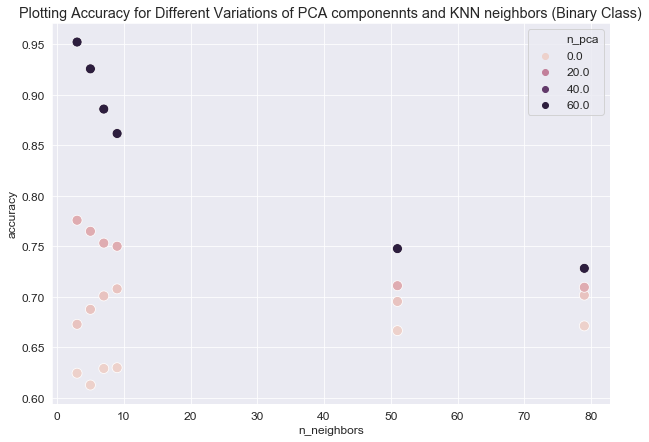

In [63]:
# plotting KNN accuracies with different PCA components and k-nearest neighbors (binary class)

plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 12})
sns.scatterplot(data=knn_df, x='n_neighbors', y='accuracy', hue = 'n_pca', s=100)
plt.title('Plotting Accuracy for Different Variations of PCA componennts and KNN neighbors (Binary Class)')

Text(0.5, 1.0, 'Plotting Accuracy for Different Variations of PCA componennts and KNN neighbors (Multi Class)')

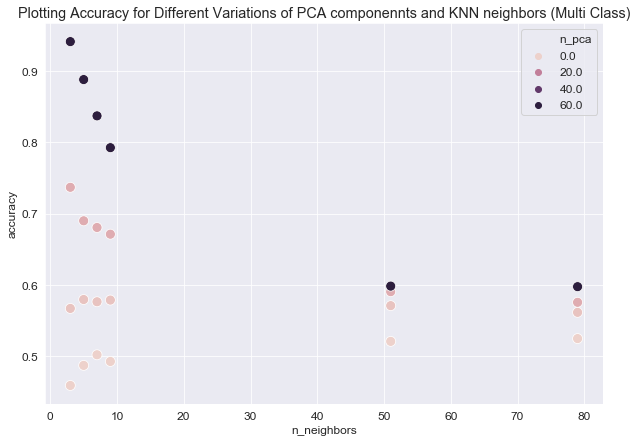

In [64]:
# plotting KNN accuracies with different PCA components and k-nearest neighbors (multi class)

plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 12})
sns.scatterplot(data=knn_m_df, x='n_neighbors', y='accuracy', hue = 'n_pca', s=100)
plt.title('Plotting Accuracy for Different Variations of PCA componennts and KNN neighbors (Multi Class)')

### Using best params to check accuracy on test data

In [65]:
# best params for binary class data
knn_df[knn_df.accuracy == max(knn_df.accuracy)] 

,n_pca,n_neighbors,accuracy
18,50.0,3.0,0.952344


In [66]:
# best params for multi class data
knn_m_df[knn_m_df.accuracy == max(knn_m_df.accuracy)]

,n_pca,n_neighbors,accuracy
18,50.0,3.0,0.940625


In [67]:
def knn_test(df, train_data, train_label, test_data, test_labels):

    # get best params
    best_params = df[df.accuracy == max(df.accuracy)]
    
    # transform data into pca
    pca = PCA(n_components=int(best_params.n_pca.item()))
    pca_train = pca.fit_transform(train_data)
    pca_test = pca.transform(test_data)
    
    knn = KNeighborsClassifier(n_neighbors=int(best_params.n_neighbors.item()))
    knn.fit(pca_train, train_label)
    y_pred = knn.predict(pca_test)
    knn_acc = accuracy_score(test_labels, y_pred)
    
    return knn_acc

In [68]:
bi_acc = knn_test(knn_df, X_train, Y_train, X_test, Y_test)
multi_acc = knn_test(knn_m_df, X_m_train, Y_m_train, X_m_test, Y_m_test)

print(f'Accuracy (binary class): {bi_acc}')
print(f'Accuracy (multi class): {multi_acc}')

Accuracy (binary class): 0.95625
Accuracy (multi class): 0.934375


### Conclusion: KNN performs really well (fast and accurate), especially with PCA transformation because of dimension reduction. 